In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2

import os
import shutil
import stat
from os import listdir
from os.path import isfile, join

import collections
from collections import defaultdict

import h5py
import multiprocessing as mp

from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

Using TensorFlow backend.


In [6]:
root = '/tmp/food-101/food-101/'
root_dir = root + 'images'

# Display a random image from each class

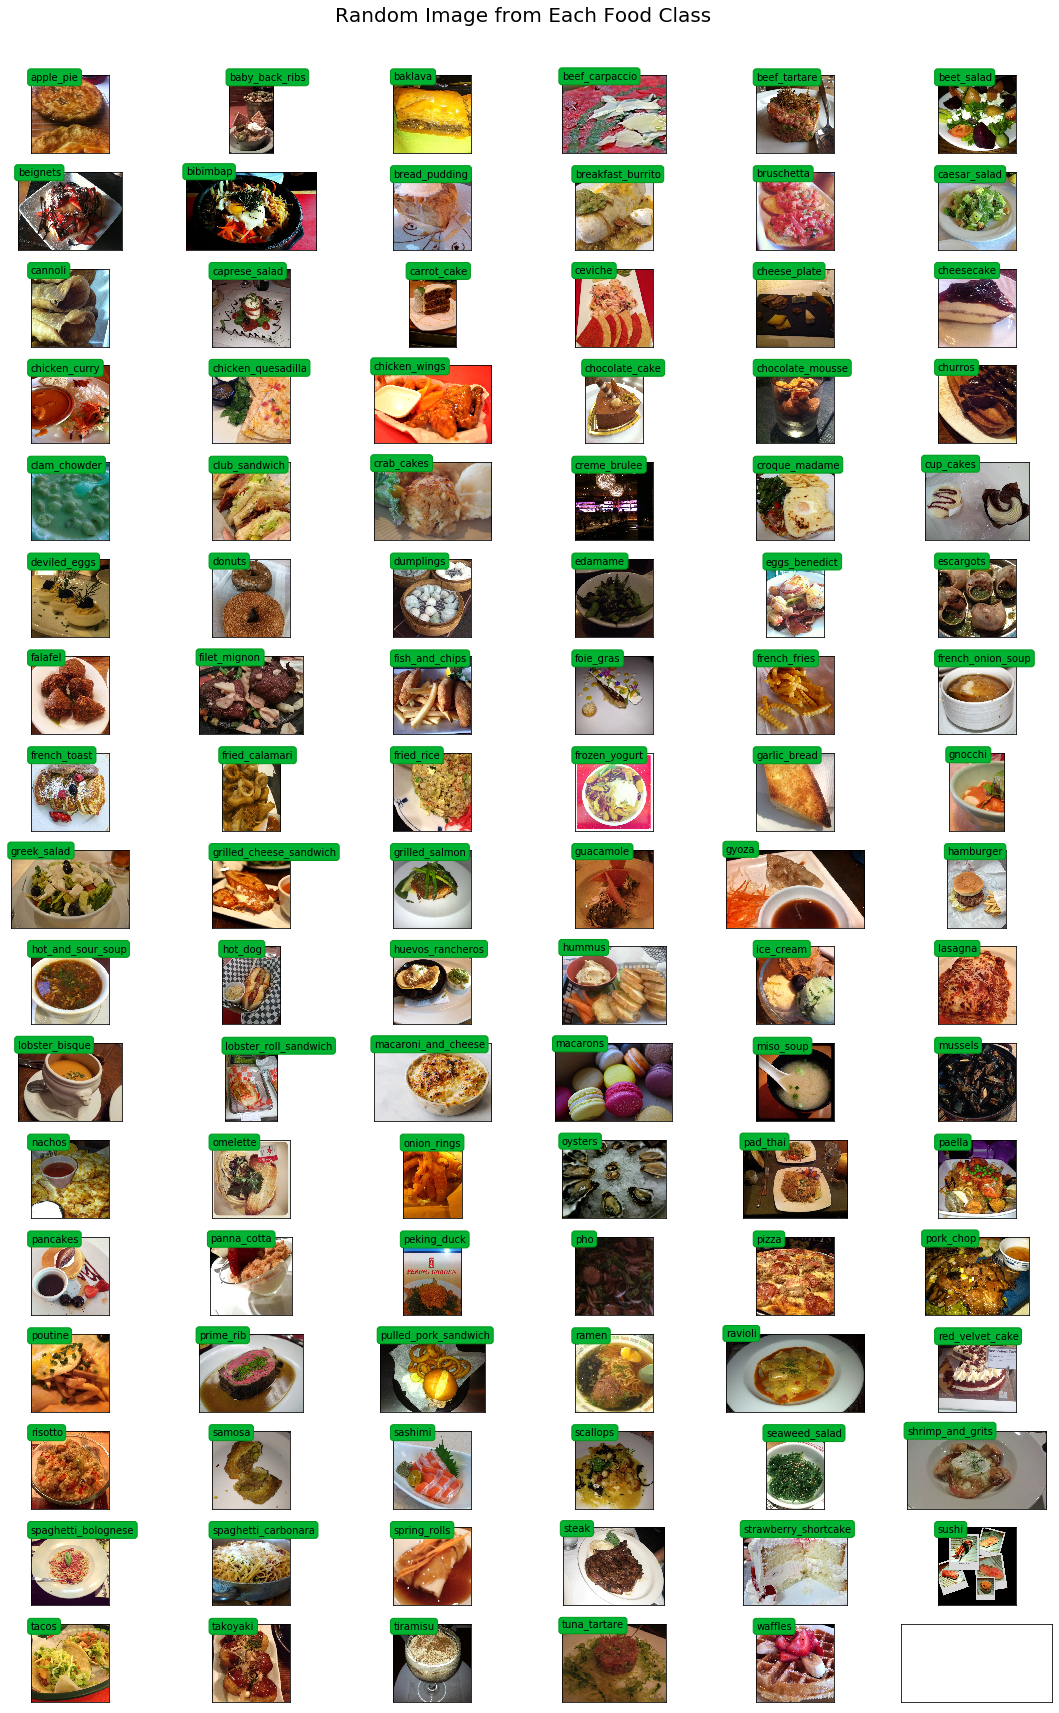

In [7]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))

plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create an index out of each label

In [8]:
class_to_ix = {}
ix_to_class = {}
with open(root + 'meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

# Split the data into training and test folders. 
## The Food-101 dataset has a provided train/test split. We want to use this in order to compare our classifcation performance with other implementations.

In [9]:
test_dir = root + 'test'
train_dir = root + 'train'

# Only split into test and train if you haven't already !
if not os.path.isdir(test_dir) and not os.path.isdir(train_dir):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map(root + 'meta/train.txt')
    test_dir_files = generate_dir_file_map(root + 'meta/test.txt')

    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree(root + 'images', root + 'test', ignore=ignore_train)
    copytree(root + 'images', root + 'train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

Train/Test files already copied into separate folders.


# Load training and testing data into memory. 

## Approach

Read each file from training / test directory using cv2.imread function. This function internally assumes that images are in BGR channel.
So, we convert them back to RGB for further processing. 
The images in the dataset have maximum side length of 512, but the images can be of different size within that.  We resize each image to have the size (128, 128, 3). 

## Alternatives considered
The current size used (128, 128, 3) produces low quality images. But, this consumes less memory and is computationally fast.
When (299, 299, 3) size images were used, the process was crashing due to OutOfMemoryException

In [10]:
# Load dataset images and resize to meet minimum width and height pixel size
def load_images(root, min_side=299):
    all_imgs = []
    all_classes = []
    resize_count = 0
    invalid_count = 0
    for i, subdir in enumerate(listdir(root)):
        imgs = listdir(join(root, subdir))
        class_ix = class_to_ix[subdir]
        print(i, class_ix, subdir)
        for img_name in imgs:
            img_arr = cv2.imread(join(root, subdir, img_name))
            img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            try:
                w, h, _ = img_arr.shape
                
                img_arr_rs = cv2.resize(img_arr, (128, 128), interpolation = cv2.INTER_AREA)
                '''
                if w < min_side:
                    wpercent = (min_side/float(w))
                    hsize = int((float(h)*float(wpercent)))
                    #print('new dims:', min_side, hsize)
                    img_arr_rs = cv2.resize(img_arr, (min_side, hsize))
                    resize_count += 1
                elif h < min_side:
                    hpercent = (min_side/float(h))
                    wsize = int((float(w)*float(hpercent)))
                    #print('new dims:', wsize, min_side)
                    img_arr_rs = cv2.resize(img_arr, (wsize, min_side))
                    resize_count += 1
                '''
                
                all_imgs.append(img_arr_rs)
                all_classes.append(class_ix)
            except:
                print('Skipping bad image: ', subdir, img_name)
                invalid_count += 1

    print(len(all_imgs), 'images loaded')
    print(resize_count, 'images resized')
    print(invalid_count, 'images skipped')
    return np.array(all_imgs), np.array(all_classes)

In [11]:
X_test, y_test = load_images(test_dir, min_side=128)

0 17 cheese_plate
1 65 mussels
2 4 beef_tartare
3 57 hummus
4 67 omelette
5 42 french_toast
6 63 macarons
7 5 beet_salad
8 51 guacamole
9 32 dumplings
10 0 apple_pie
11 97 takoyaki
12 87 scallops
13 84 risotto
14 82 ravioli
15 62 macaroni_and_cheese
16 19 chicken_quesadilla
17 69 oysters
18 20 chicken_wings
19 24 clam_chowder
20 71 paella
21 95 sushi
22 54 hot_and_sour_soup
23 37 filet_mignon
24 94 strawberry_shortcake
25 99 tuna_tartare
26 89 shrimp_and_grits
27 90 spaghetti_bolognese
28 23 churros
29 47 gnocchi
30 33 edamame
31 7 bibimbap
32 35 escargots
33 55 hot_dog
34 1 baby_back_ribs
35 39 foie_gras
36 85 samosa
37 98 tiramisu
38 53 hamburger
39 13 caprese_salad
40 96 tacos
41 28 croque_madame
42 30 deviled_eggs
43 6 beignets
44 79 prime_rib
45 11 caesar_salad
46 74 peking_duck
47 2 baklava
48 34 eggs_benedict
49 27 creme_brulee
50 3 beef_carpaccio
51 45 frozen_yogurt
52 73 panna_cotta
53 70 pad_thai
54 59 lasagna
55 68 onion_rings
56 83 red_velvet_cake
57 76 pizza
58 16 cheeseca

In [12]:
X_train, y_train = load_images(train_dir, min_side=128)

0 17 cheese_plate
1 65 mussels
2 4 beef_tartare
3 57 hummus
4 67 omelette
5 42 french_toast
6 63 macarons
7 5 beet_salad
8 51 guacamole
9 32 dumplings
10 0 apple_pie
11 97 takoyaki
12 87 scallops
13 84 risotto
14 82 ravioli
15 62 macaroni_and_cheese
16 19 chicken_quesadilla
17 69 oysters
18 20 chicken_wings
19 24 clam_chowder
20 71 paella
21 95 sushi
22 54 hot_and_sour_soup
23 37 filet_mignon
24 94 strawberry_shortcake
25 99 tuna_tartare
26 89 shrimp_and_grits
27 90 spaghetti_bolognese
28 23 churros
29 47 gnocchi
30 33 edamame
31 7 bibimbap
32 35 escargots
33 55 hot_dog
34 1 baby_back_ribs
35 39 foie_gras
36 85 samosa
37 98 tiramisu
38 53 hamburger
39 13 caprese_salad
40 96 tacos
41 28 croque_madame
42 30 deviled_eggs
43 6 beignets
44 79 prime_rib
45 11 caesar_salad
46 74 peking_duck
47 2 baklava
48 34 eggs_benedict
49 27 creme_brulee
50 3 beef_carpaccio
51 45 frozen_yogurt
52 73 panna_cotta
53 70 pad_thai
54 59 lasagna
55 68 onion_rings
56 83 red_velvet_cake
57 76 pizza
58 16 cheeseca

Random training and testing image

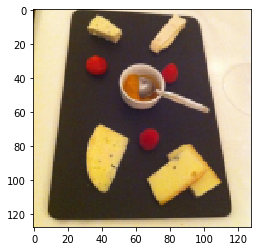

In [221]:
plt.imshow(X_train[45])

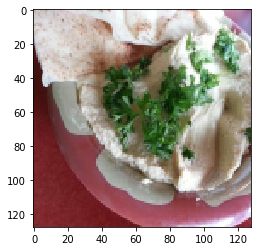

In [222]:
plt.imshow(X_test[890])

Reshape both training and testing data to 2-D from 4-D. We need to do this before passing the features to the model.

In [183]:
nsamples, h, w, c = X_train.shape
n_test, h1, w1, c1 = X_test.shape

X_train_new = X_train.reshape(nsamples, (h*w*c))
X_test_new = X_test.reshape(n_test, (h1*w1*c1))

In [184]:
import random

shuffledRange = list(range(nsamples))

random.shuffle(shuffledRange)

shuffledX = [X_train_new[i] for i in shuffledRange]
X_train_new = shuffledX

y_train_new = [y_train[i] for i in shuffledRange]

In [185]:
shuffledRange = list(range(n_test))
random.shuffle(shuffledRange)

shuffledX = [X_test_new[i] for i in shuffledRange]
X_test_new = shuffledX

y_test_new = [y_test[i] for i in shuffledRange]

Utility method for streaming images. This method is a generator which yields a stream of training images and labels. Internally this method also scales the images to 0 - 1 range. 

In [14]:
def stream_images(X_train, y_train):
    n = np.shape(X_train)[0]
    for x in range(n):
        yield X_train[x] / 255.0, y_train[x]

In [15]:
next(stream_images(X_train, y_train))

(array([[[0.61568627, 0.6627451 , 0.83529412],
         [0.56470588, 0.57647059, 0.75686275],
         [0.5254902 , 0.54509804, 0.72156863],
         ...,
         [0.55686275, 0.46666667, 0.41176471],
         [0.56078431, 0.4627451 , 0.4       ],
         [0.54901961, 0.45098039, 0.38039216]],
 
        [[0.45882353, 0.52156863, 0.71764706],
         [0.44705882, 0.48627451, 0.68627451],
         [0.43921569, 0.4745098 , 0.67058824],
         ...,
         [0.58039216, 0.48627451, 0.43529412],
         [0.58039216, 0.48627451, 0.43529412],
         [0.57647059, 0.47058824, 0.42745098]],
 
        [[0.53333333, 0.58431373, 0.77254902],
         [0.54901961, 0.58039216, 0.77254902],
         [0.54901961, 0.58039216, 0.76862745],
         ...,
         [0.57647059, 0.48627451, 0.43529412],
         [0.58039216, 0.48627451, 0.44705882],
         [0.57647059, 0.4745098 , 0.44705882]],
 
        ...,
 
        [[0.61568627, 0.53333333, 0.53333333],
         [0.64705882, 0.56470588, 0.56078

In [186]:
print('X_train shape', np.shape(X_train_new))
print('y_train shape', np.shape(y_train_new))
print('X_test shape', np.shape(X_test_new))
print('y_test shape', np.shape(y_test_new))

X_train shape (75750, 49152)
y_train shape (75750,)
X_test shape (25250, 49152)
y_test shape (25250,)


Utility method for creating mini batches of specific sizes provided in the input. This method takes in image_stream as input and creates batches of specific size using the image stream.

In [17]:
def get_minibatch(image_stream, size):
    images, y = [], []
    for _ in range(size):
        try:
            image, label = next(image_stream)
            images.append(image)
            y.append(label)
        except:
            return images, y
    return images, y

We wanted to do classification using RidgeRegression directly. But, due to the huge size of the dataset, Ridge Regression cannot be applied directly. We tried to achieve
the same on three different host types with RAM 16GB, 31GB and 500GB. But the process crashed in each of the host with out of memory exception. 

Hence, we are training the model iteratively using stochastic gradient descent. 

Even using stochastic gradient descent, the model takes ~1.5 hours to train. Hence, the following snippets only consider part of the dataset (ie) first 7500 images for training and 2500 for testing. All of the following results were obtained on p3.16x large host on AWS Sagemaker. 

# Classifier 1: SGD Classifier using squared loss and $\lambda=0.001$

In [190]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='squared_loss', random_state=1, alpha=1e-3, tol=1e-2)
image_stream = stream_images(X_train_new, y_train_new)

In [191]:
classes = np.unique(y_train_new[:7500])
print(np.shape(classes))

(101,)


In [192]:
overall_accuracy = 0

for x in range(10):
    x_t, y_t = get_minibatch(image_stream, size=750)
    clf = clf.partial_fit(x_t, y_t, classes=classes)
    accuracy = clf.score(x_t, y_t)
    overall_accuracy = overall_accuracy + accuracy
    print('Iteration completed ---> ', str(x+1))
    print('Accuracy for this batch is -->', accuracy)

print('---------------------------')
print('Overall Training accuracy is -->', overall_accuracy / 10)

Iteration completed --->  1
Accuracy for this batch is --> 0.013333333333333334
Iteration completed --->  2
Accuracy for this batch is --> 0.016
Iteration completed --->  3
Accuracy for this batch is --> 0.012
Iteration completed --->  4
Accuracy for this batch is --> 0.009333333333333334
Iteration completed --->  5
Accuracy for this batch is --> 0.009333333333333334
Iteration completed --->  6
Accuracy for this batch is --> 0.006666666666666667
Iteration completed --->  7
Accuracy for this batch is --> 0.010666666666666666
Iteration completed --->  8
Accuracy for this batch is --> 0.006666666666666667
Iteration completed --->  9
Accuracy for this batch is --> 0.012
Iteration completed --->  10
Accuracy for this batch is --> 0.012
---------------------------
Overall Training accuracy is --> 0.0108


In [193]:
test_stream = stream_images(X_test_new, y_test_new)

In [194]:
overall_accuracy = 0

for x in range(10):
    X_test_hat, y_test_hat = get_minibatch(test_stream, size=250)
    accuracy = clf.score(X_test_hat, y_test_hat)
    overall_accuracy = overall_accuracy + accuracy
    print('Iteration completed ---> ', str(x+1))
    print('Accuracy for this batch is -->', accuracy)

print('---------------------------')
print('Overall Testing accuracy is -->', overall_accuracy / 10)

Iteration completed --->  1
Accuracy for this batch is --> 0.024
Iteration completed --->  2
Accuracy for this batch is --> 0.0
Iteration completed --->  3
Accuracy for this batch is --> 0.02
Iteration completed --->  4
Accuracy for this batch is --> 0.008
Iteration completed --->  5
Accuracy for this batch is --> 0.012
Iteration completed --->  6
Accuracy for this batch is --> 0.012
Iteration completed --->  7
Accuracy for this batch is --> 0.02
Iteration completed --->  8
Accuracy for this batch is --> 0.004
Iteration completed --->  9
Accuracy for this batch is --> 0.016
Iteration completed --->  10
Accuracy for this batch is --> 0.02
---------------------------
Overall Testing accuracy is --> 0.013600000000000001


# Classifier 2: SGD Classifier using log loss and $\lambda=0.001$

In [195]:
clf2 = SGDClassifier(loss='log', random_state=1, alpha=1e-3, tol=1e-2)
image_stream = stream_images(X_train_new, y_train_new)

In [196]:
overall_accuracy = 0

for x in range(10):
    x_t, y_t = get_minibatch(image_stream, size=750)
    clf2 = clf2.partial_fit(x_t, y_t, classes=classes)
    accuracy = clf2.score(x_t, y_t)
    overall_accuracy = overall_accuracy + accuracy
    print('Iteration completed ---> ', str(x+1))
    print('Accuracy for this batch is -->', accuracy)

print('---------------------------')
print('Overall Training accuracy is -->', overall_accuracy / 10)

Iteration completed --->  1
Accuracy for this batch is --> 0.06133333333333333
Iteration completed --->  2
Accuracy for this batch is --> 0.030666666666666665
Iteration completed --->  3
Accuracy for this batch is --> 0.05333333333333334
Iteration completed --->  4
Accuracy for this batch is --> 0.06533333333333333
Iteration completed --->  5
Accuracy for this batch is --> 0.042666666666666665
Iteration completed --->  6
Accuracy for this batch is --> 0.018666666666666668
Iteration completed --->  7
Accuracy for this batch is --> 0.06533333333333333
Iteration completed --->  8
Accuracy for this batch is --> 0.04133333333333333
Iteration completed --->  9
Accuracy for this batch is --> 0.04133333333333333
Iteration completed --->  10
Accuracy for this batch is --> 0.06133333333333333
---------------------------
Overall Training accuracy is --> 0.04813333333333334


In [197]:
test_stream = stream_images(X_test_new, y_test_new)

In [198]:
overall_accuracy = 0

for x in range(10):
    X_test_hat, y_test_hat = get_minibatch(test_stream, size=250)
    accuracy = clf2.score(X_test_hat, y_test_hat)
    overall_accuracy = overall_accuracy + accuracy
    print('Iteration completed ---> ', str(x+1))
    print('Accuracy for this batch is -->', accuracy)

print('---------------------------')
print('Overall Testing accuracy is -->', overall_accuracy / 10)

Iteration completed --->  1
Accuracy for this batch is --> 0.012
Iteration completed --->  2
Accuracy for this batch is --> 0.004
Iteration completed --->  3
Accuracy for this batch is --> 0.008
Iteration completed --->  4
Accuracy for this batch is --> 0.004
Iteration completed --->  5
Accuracy for this batch is --> 0.012
Iteration completed --->  6
Accuracy for this batch is --> 0.016
Iteration completed --->  7
Accuracy for this batch is --> 0.02
Iteration completed --->  8
Accuracy for this batch is --> 0.012
Iteration completed --->  9
Accuracy for this batch is --> 0.036
Iteration completed --->  10
Accuracy for this batch is --> 0.016
---------------------------
Overall Testing accuracy is --> 0.014000000000000002


# Classifier 3: SGD Classifier using hinge loss and $\lambda=0.001$

In [201]:
clf3 = SGDClassifier(loss='hinge', random_state=1, alpha=10, tol=1e-2)
image_stream = stream_images(X_train_new, y_train_new)

In [202]:
overall_accuracy = 0

for x in range(10):
    x_t, y_t = get_minibatch(image_stream, size=750)
    clf3 = clf3.partial_fit(x_t, y_t, classes=classes)
    accuracy = clf3.score(x_t, y_t)
    overall_accuracy = overall_accuracy + accuracy
    print('Iteration completed ---> ', str(x+1))
    print('Accuracy for this batch is -->', accuracy)

print('---------------------------')
print('Overall Training accuracy is -->', overall_accuracy / 10)

Iteration completed --->  1
Accuracy for this batch is --> 0.02266666666666667
Iteration completed --->  2
Accuracy for this batch is --> 0.03866666666666667
Iteration completed --->  3
Accuracy for this batch is --> 0.03866666666666667
Iteration completed --->  4
Accuracy for this batch is --> 0.034666666666666665
Iteration completed --->  5
Accuracy for this batch is --> 0.04933333333333333
Iteration completed --->  6
Accuracy for this batch is --> 0.03333333333333333
Iteration completed --->  7
Accuracy for this batch is --> 0.06
Iteration completed --->  8
Accuracy for this batch is --> 0.07866666666666666
Iteration completed --->  9
Accuracy for this batch is --> 0.02666666666666667
Iteration completed --->  10
Accuracy for this batch is --> 0.029333333333333333
---------------------------
Overall Training accuracy is --> 0.0412


In [203]:
test_stream = stream_images(X_test_new, y_test_new)

In [204]:
overall_accuracy = 0

for x in range(10):
    X_test_hat, y_test_hat = get_minibatch(test_stream, size=250)
    accuracy = clf3.score(X_test_hat, y_test_hat)
    
    overall_accuracy = overall_accuracy + accuracy
    print('Iteration completed ---> ', str(x+1))
    print('Accuracy for this batch is -->', accuracy)

print('---------------------------')
print('Overall Testing accuracy is -->', overall_accuracy / 10)

Iteration completed --->  1
Accuracy for this batch is --> 0.024
Iteration completed --->  2
Accuracy for this batch is --> 0.036
Iteration completed --->  3
Accuracy for this batch is --> 0.016
Iteration completed --->  4
Accuracy for this batch is --> 0.012
Iteration completed --->  5
Accuracy for this batch is --> 0.008
Iteration completed --->  6
Accuracy for this batch is --> 0.012
Iteration completed --->  7
Accuracy for this batch is --> 0.028
Iteration completed --->  8
Accuracy for this batch is --> 0.028
Iteration completed --->  9
Accuracy for this batch is --> 0.012
Iteration completed --->  10
Accuracy for this batch is --> 0.02
---------------------------
Overall Testing accuracy is --> 0.0196


# Classifier 4: SGD Classifier using hinge loss and $\lambda=10$

In [205]:
clf4 = SGDClassifier(loss='hinge', random_state=1, alpha=10, tol=1e-2)
image_stream = stream_images(X_train_new, y_train_new)

In [206]:
overall_accuracy = 0

for x in range(10):
    x_t, y_t = get_minibatch(image_stream, size=750)
    clf4 = clf4.partial_fit(x_t, y_t, classes=classes)
    accuracy = clf4.score(x_t, y_t)
    overall_accuracy = overall_accuracy + accuracy
    print('Iteration completed ---> ', str(x+1))
    print('Accuracy for this batch is -->', accuracy)

print('---------------------------')
print('Overall Training accuracy is -->', overall_accuracy / 10)

Iteration completed --->  1
Accuracy for this batch is --> 0.02266666666666667
Iteration completed --->  2
Accuracy for this batch is --> 0.03866666666666667
Iteration completed --->  3
Accuracy for this batch is --> 0.03866666666666667
Iteration completed --->  4
Accuracy for this batch is --> 0.034666666666666665
Iteration completed --->  5
Accuracy for this batch is --> 0.04933333333333333
Iteration completed --->  6
Accuracy for this batch is --> 0.03333333333333333
Iteration completed --->  7
Accuracy for this batch is --> 0.06
Iteration completed --->  8
Accuracy for this batch is --> 0.07866666666666666
Iteration completed --->  9
Accuracy for this batch is --> 0.02666666666666667
Iteration completed --->  10
Accuracy for this batch is --> 0.029333333333333333
---------------------------
Overall Training accuracy is --> 0.0412


In [207]:
test_stream = stream_images(X_test_new, y_test_new)

In [208]:
overall_accuracy = 0

for x in range(10):
    X_test_hat, y_test_hat = get_minibatch(test_stream, size=250)
    accuracy = clf4.score(X_test_hat, y_test_hat)
    
    overall_accuracy = overall_accuracy + accuracy
    print('Iteration completed ---> ', str(x+1))
    print('Accuracy for this batch is -->', accuracy)

print('---------------------------')
print('Overall Testing accuracy is -->', overall_accuracy / 10)

Iteration completed --->  1
Accuracy for this batch is --> 0.024
Iteration completed --->  2
Accuracy for this batch is --> 0.036
Iteration completed --->  3
Accuracy for this batch is --> 0.016
Iteration completed --->  4
Accuracy for this batch is --> 0.012
Iteration completed --->  5
Accuracy for this batch is --> 0.008
Iteration completed --->  6
Accuracy for this batch is --> 0.012
Iteration completed --->  7
Accuracy for this batch is --> 0.028
Iteration completed --->  8
Accuracy for this batch is --> 0.028
Iteration completed --->  9
Accuracy for this batch is --> 0.012
Iteration completed --->  10
Accuracy for this batch is --> 0.02
---------------------------
Overall Testing accuracy is --> 0.0196


# Classifier 5: SGD Classifier using hinge loss and $\lambda=30$

In [210]:
clf5 = SGDClassifier(loss='hinge', random_state=1, alpha=30, tol=1e-2)
image_stream = stream_images(X_train_new, y_train_new)

In [211]:
overall_accuracy = 0

for x in range(10):
    x_t, y_t = get_minibatch(image_stream, size=750)
    clf5 = clf5.partial_fit(x_t, y_t, classes=classes)
    accuracy = clf5.score(x_t, y_t)
    overall_accuracy = overall_accuracy + accuracy
    print('Iteration completed ---> ', str(x+1))
    print('Accuracy for this batch is -->', accuracy)

print('---------------------------')
print('Overall Training accuracy is -->', overall_accuracy / 10)

Iteration completed --->  1
Accuracy for this batch is --> 0.03866666666666667
Iteration completed --->  2
Accuracy for this batch is --> 0.021333333333333333
Iteration completed --->  3
Accuracy for this batch is --> 0.048
Iteration completed --->  4
Accuracy for this batch is --> 0.02666666666666667
Iteration completed --->  5
Accuracy for this batch is --> 0.03866666666666667
Iteration completed --->  6
Accuracy for this batch is --> 0.03866666666666667
Iteration completed --->  7
Accuracy for this batch is --> 0.034666666666666665
Iteration completed --->  8
Accuracy for this batch is --> 0.02266666666666667
Iteration completed --->  9
Accuracy for this batch is --> 0.02266666666666667
Iteration completed --->  10
Accuracy for this batch is --> 0.029333333333333333
---------------------------
Overall Training accuracy is --> 0.03213333333333333


In [212]:
test_stream = stream_images(X_test_new, y_test_new)

In [213]:
overall_accuracy = 0

for x in range(10):
    X_test_hat, y_test_hat = get_minibatch(test_stream, size=250)
    accuracy = clf5.score(X_test_hat, y_test_hat)
    
    overall_accuracy = overall_accuracy + accuracy
    print('Iteration completed ---> ', str(x+1))
    print('Accuracy for this batch is -->', accuracy)

print('---------------------------')
print('Overall Testing accuracy is -->', overall_accuracy / 10)

Iteration completed --->  1
Accuracy for this batch is --> 0.012
Iteration completed --->  2
Accuracy for this batch is --> 0.016
Iteration completed --->  3
Accuracy for this batch is --> 0.02
Iteration completed --->  4
Accuracy for this batch is --> 0.02
Iteration completed --->  5
Accuracy for this batch is --> 0.028
Iteration completed --->  6
Accuracy for this batch is --> 0.02
Iteration completed --->  7
Accuracy for this batch is --> 0.004
Iteration completed --->  8
Accuracy for this batch is --> 0.012
Iteration completed --->  9
Accuracy for this batch is --> 0.012
Iteration completed --->  10
Accuracy for this batch is --> 0.008
---------------------------
Overall Testing accuracy is --> 0.015200000000000002


# Classifier 6: Training on entire data using hingle loss and $\lambda=10$

In [216]:
clf6 = SGDClassifier(loss='hinge', random_state=1, alpha=10, tol=1e-2)
image_stream = stream_images(X_train_new, y_train_new)

In [217]:
classes = np.unique(y_train)
print(np.shape(classes))

(101,)


In [218]:
overall_accuracy = 0

for x in range(101):
    x_t, y_t = get_minibatch(image_stream, size=750)
    clf6 = clf6.partial_fit(x_t, y_t, classes=classes)
    accuracy = clf6.score(x_t, y_t)
    overall_accuracy = overall_accuracy + accuracy
    print('Iteration completed ---> ', str(x+1))
    print('Accuracy for this batch is -->', accuracy)

print('---------------------------')
print('Overall Training accuracy is -->', overall_accuracy / 10)

Iteration completed --->  1
Accuracy for this batch is --> 0.02266666666666667
Iteration completed --->  2
Accuracy for this batch is --> 0.03866666666666667
Iteration completed --->  3
Accuracy for this batch is --> 0.03866666666666667
Iteration completed --->  4
Accuracy for this batch is --> 0.034666666666666665
Iteration completed --->  5
Accuracy for this batch is --> 0.04933333333333333
Iteration completed --->  6
Accuracy for this batch is --> 0.03333333333333333
Iteration completed --->  7
Accuracy for this batch is --> 0.06
Iteration completed --->  8
Accuracy for this batch is --> 0.07866666666666666
Iteration completed --->  9
Accuracy for this batch is --> 0.02666666666666667
Iteration completed --->  10
Accuracy for this batch is --> 0.029333333333333333
Iteration completed --->  11
Accuracy for this batch is --> 0.034666666666666665
Iteration completed --->  12
Accuracy for this batch is --> 0.058666666666666666
Iteration completed --->  13
Accuracy for this batch is --> 

In [219]:
test_stream = stream_images(X_test_new, y_test_new)

In [220]:
overall_accuracy = 0

for x in range(101):
    X_test_hat, y_test_hat = get_minibatch(test_stream, size=250)
    accuracy = clf6.score(X_test_hat, y_test_hat)
    
    overall_accuracy = overall_accuracy + accuracy
    print('Iteration completed ---> ', str(x+1))
    print('Accuracy for this batch is -->', accuracy)

print('---------------------------')
print('Overall Testing accuracy is -->', overall_accuracy / 101)

Iteration completed --->  1
Accuracy for this batch is --> 0.016
Iteration completed --->  2
Accuracy for this batch is --> 0.04
Iteration completed --->  3
Accuracy for this batch is --> 0.032
Iteration completed --->  4
Accuracy for this batch is --> 0.032
Iteration completed --->  5
Accuracy for this batch is --> 0.04
Iteration completed --->  6
Accuracy for this batch is --> 0.028
Iteration completed --->  7
Accuracy for this batch is --> 0.072
Iteration completed --->  8
Accuracy for this batch is --> 0.04
Iteration completed --->  9
Accuracy for this batch is --> 0.04
Iteration completed --->  10
Accuracy for this batch is --> 0.032
Iteration completed --->  11
Accuracy for this batch is --> 0.02
Iteration completed --->  12
Accuracy for this batch is --> 0.056
Iteration completed --->  13
Accuracy for this batch is --> 0.04
Iteration completed --->  14
Accuracy for this batch is --> 0.04
Iteration completed --->  15
Accuracy for this batch is --> 0.028
Iteration completed --->  